In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_prd_temperature_data(base_path,base):
    data = {}
    prod_root = os.path.join(base_path, base)

    for scenario in os.listdir(prod_root):
        scenario_path = os.path.join(prod_root, scenario)
        if not os.path.isdir(scenario_path):
            continue

        # break off q and WR
        parts = [p.strip() for p in scenario.split(',')]
        q_value  = parts[0]                   # 'q=0' or 'q=3.1e-07'
        well_rate = parts[1] if len(parts)>1 else ''  # 'WR=8000'

        for model_dir in os.listdir(scenario_path):
            model_path = os.path.join(scenario_path, model_dir)
            if not os.path.isdir(model_path):
                continue

            mp = [p.strip() for p in model_dir.split(',')]
            model_name = mp[0]                # 'homogeneous' or 'model 0'
            q_key = q_value
            if len(mp)>1:
                q_key += f', {mp[1]}'         # add 'dir=…' if present

            fname = os.path.join(model_path, 'time_data.xlsx')
            df = pd.read_excel(fname, usecols=['time','PRD : temperature (K)'])
            data.setdefault(model_name, {})[(q_key, well_rate)] = df

    return data

def plot_collection(data, q_value, well_rate, diff=False):
    models = ['homogeneous','model 0','model 1','model 2','model 3','model 4']
    fig, axes = plt.subplots(3,2,figsize=(14,11),sharex=True,sharey=not diff)
    axes = axes.flatten()
    
    base_key = 'q=0'
    
    for ax, model in zip(axes, models):
        series = {q:df for (q,wr),df in data.get(model,{}).items() if wr==well_rate}
        if diff:
            df0 = series.get(base_key)
            t0, T0 = df0['time'].values, df0['PRD : temperature (K)'].values
        
        # plot each series
        for q_key in sorted(series, key=legend_sort_key):
            if diff:
                if q_key==base_key or not q_key.startswith(q_value):
                    continue
                df = series[q_key]
                t, T = df['time'].values, df['PRD : temperature (K)'].values
                y = T - np.interp(t, t0, T0)
                label = q_key
            else:
                if not (q_key == base_key or q_key.startswith(q_value)):
                    continue
                df = series[q_key]
                t, y = df['time'].values, df['PRD : temperature (K)'].values
                label = q_key
            
            ax.plot(
                t/365, y, label=label,
                linestyle='--' if (not diff and q_key==base_key) else None,
                color='gray' if (not diff and q_key==base_key) else None
            )
        
        ax.set_title(model)
        ax.grid(True)
    
    # build a single legend on the figure, to the right
    handles, labels = axes[0].get_legend_handles_labels()
    legend_title = 'Background flowrate, direction' 
    fig.legend(
        handles, labels,
        title=legend_title,
        loc='center left',
        bbox_to_anchor=(0.92, 0.5),
        borderaxespad=0.0
    )

    kind = 'Temperature Difference' if diff else 'Temperature'
    fig.suptitle(f"PRD {kind} vs Time: {q_value}, {well_rate}", fontsize=14)
    fig.text(0.5, 0.04, 'Time (years)', ha='center')
    ylabel = r'$\Delta T$ (K) relative to q=0' if diff else 'PRD : temperature (K)'
    fig.text(0.04, 0.5, ylabel, va='center', rotation='vertical')
    fig.tight_layout(rect=[0.05,0.05,0.88,0.93])
    plt.show()

def legend_sort_key(q_key):
    if q_key.startswith("q=0"):
        return (0, 0)
    if "dir=" in q_key:
        angle_part = q_key.split("dir=", 1)[1]
        angle_str = angle_part.split()[0].rstrip(",")
        return (1, int(angle_str))
    return (1, -1)

def compute_lifetimes(data):
    lifetimes = {}
    for model, series_dict in data.items():
        for (q_key, wr), df in series_dict.items():
            if ', ' in q_key:
                q_value, dir_part = q_key.split(', ', 1)
                direction = dir_part.split('=')[1]
            else:
                q_value, direction = q_key, '0'

            T0 = df['PRD : temperature (K)'].iloc[0]
            thresh = T0 - 0.15 * (T0 - 300)

            # find first time below threshold
            below = df['PRD : temperature (K)'] <= thresh
            if below.any():
                t_first = df.loc[below, 'time'].iloc[0]
                life_years = int(t_first / 365)  # floor to whole years
            else:
                life_years = pd.NA
            lifetimes.setdefault(wr, {}) \
                     .setdefault(q_value, {}) \
                     .setdefault(model, {})[direction] = life_years
    return lifetimes

def lifetime_tables(data):
    lifetimes = compute_lifetimes(data)
    models     = ['homogeneous','model 0','model 1','model 2','model 3','model 4']
    directions = ['0','45','90','135','180','225','270','315']

    for wr in sorted(lifetimes.keys(), key=lambda s: float(s.split('=')[1])):
        raw_qs   = sorted(lifetimes[wr].keys(), key=lambda q: float(q.split('=')[1]))
        clean_qs = [q.split('=')[1] for q in raw_qs]

        idx = pd.MultiIndex.from_product([models, clean_qs],
                                         names=['Model','q [m/s]'])
        df  = pd.DataFrame(index=idx, columns=directions, dtype=object)

        for raw_q, clean_q in zip(raw_qs, clean_qs):
            for model in models:
                dir_dict = lifetimes[wr][raw_q].get(model, {})
                for d in directions:
                    val = dir_dict.get(d, pd.NA)
                    if pd.notna(val):
                        df.at[(model, clean_q), d] = int(val)

        # replace missing for q>0
        for (model, qv), row in df.iterrows():
            if qv != '0':
                for d in directions:
                    if pd.isna(row[d]):
                        df.at[(model, qv), d] = "Not Reached"
            else:
                # for q=0, leave missing as blank
                for d in directions:
                    if pd.isna(row[d]):
                        df.at[(model, qv), d] = ""
        df.rename(columns={d: f"Direction: {d}" for d in directions},
                  inplace=True)

        wr_val  = wr.split('=')[1]
        caption = f"Well rate: {wr_val} m³/day"

        styler = (df.style
                    .set_caption(caption)
                    .set_table_styles([{
                        'selector': 'caption',
                        'props': [
                            ('caption-side', 'top'),
                            ('font-size', '14px'),
                            ('font-weight', 'bold')
                        ]
                    }])
                 )
        display(styler)

In [3]:
PRD_data = load_prd_temperature_data('output', 'Production')

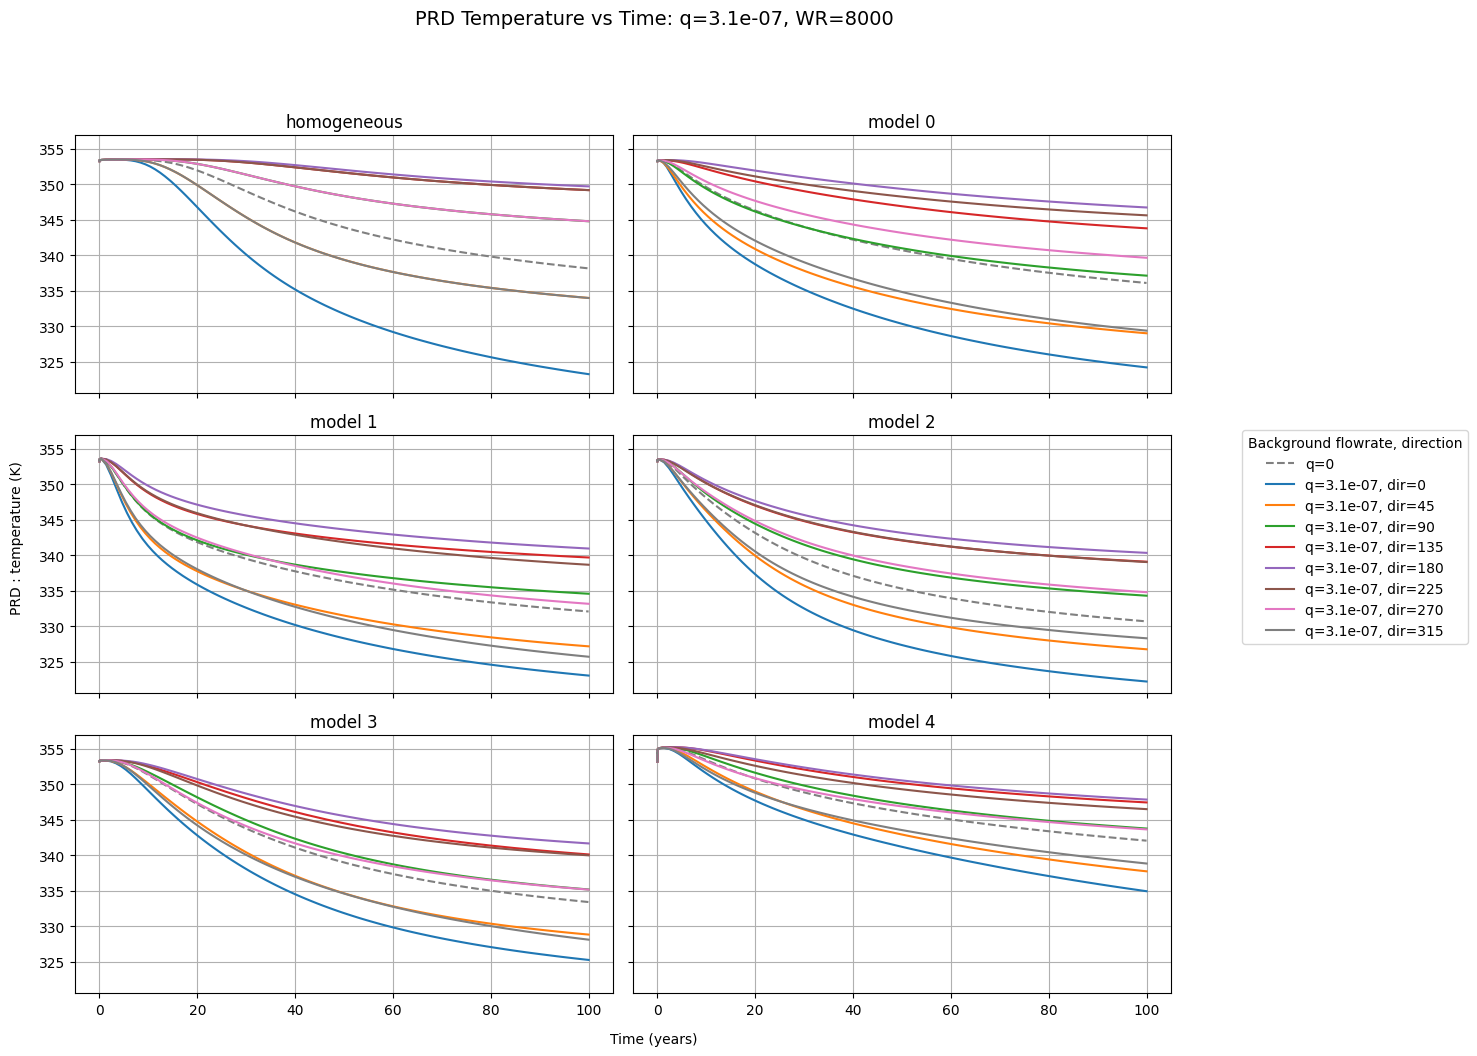

In [4]:
plot_collection(PRD_data, q_value='q=3.1e-07', well_rate='WR=8000', diff=False)

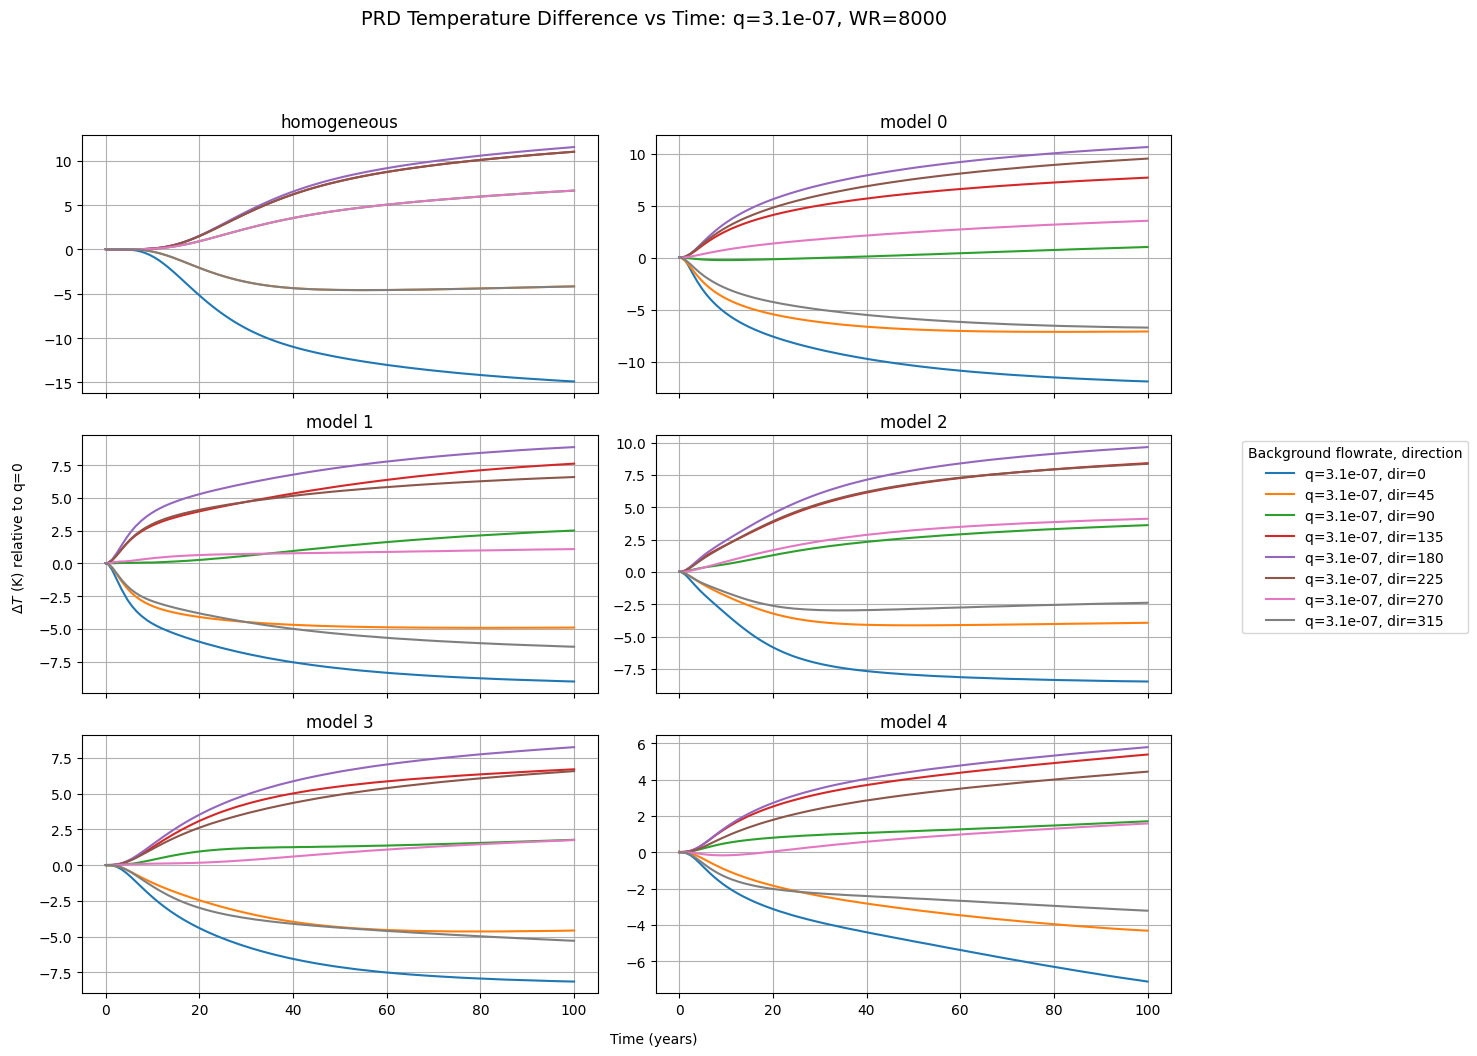

In [5]:
plot_collection(PRD_data, q_value='q=3.1e-07', well_rate='WR=8000', diff=True)

In [6]:
lifetime_tables(PRD_data)